# Testing Notebook

The goal of this notebook is to test the code, so that changes if changes are made it can be checked whether the new code is equivalent to the old code. For that, certain parameters must be kept the same. 
For redundancy, here is another specification of the parameters:
- The data folder is called testing, all files should be loaded from this folder and never be overwritten.
- The critical radius for all searching procedures is 15 
- The random seed, given at the initiation should be 0


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt#
#import matplotlib as mpl
#import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import csv

%matplotlib inline

## General and read-in routines

In [63]:
def read_in_flat(fn, conv2int = False):
    with open (fn, newline = '') as f:
        rr = csv.reader(f, delimiter = ' ')
        if conv2int: res = [int(float(line[0])) for line in rr]
        else: res = [float(line[0]) for line in rr]
    return res

def read_in_nested(fn, conv2int = False):
    with open (fn, newline = '') as f:
        rr = csv.reader(f, delimiter = ' ')
        if conv2int: res = [[int(float(i)) for i in line] for line in rr]
        else:res = [[float(i) for i in line] for line in rr]
    return res

def read_in_multiple (fn_begin, fn_end, nested, conv2int = False, ind_start = 0, max_ind = 10000):
    new_file = True
    cur_id = int(ind_start)
    res = []
    while new_file and cur_id<=max_ind:
        fn_no = fn_begin + str(cur_id)+fn_end
        try: 
            if nested: subres = read_in_nested (fn_no, conv2int)
            else: subres = read_in_flat (fn_no, conv2int)
            res.extend(subres)
            cur_id = cur_id+1
            #print (cur_id)
        except: new_file = False
    return res

def read_in_coordfile (fn, parse_ignore = True, return_list = False):
    '''
    reads in the file stored under fn (works for certain files that contain coordinates)
    Returns a np array with the data.
    If there is a problem parsing, this function will not break, however it will store it in a dict 
    If parse-ignore is set False, the number of unparsable signs as well as a set of them will be printed.
    '''
    res = []
    with open (fn, newline = '') as f:
        rr = csv.reader(f, delimiter = ' ')
        err = []
        for line in rr:
            ar = []
            for j in range(len(line)):
                try: ar.append(float(line[j]))
                except: err.append(line[j])
            res.append(np.asarray(ar))
    if len(err)> 0 and not parse_ignore: print ('Could not parse on {} instances: {}'.format(len(err), set(err)))
    if return_list: return res
    else: return np.asarray(res)

def reshape_dendcoo (dends):
    return dends.reshape((len(dends), int(len(dends[0])/3), 3))
    


In [64]:
# This function does take into account cells with 0 connections
def con_per_cell (ref, n_cells):
    cs, c_counts = np.unique(ref, return_counts = True)
    real_ccs = np.zeros(n_cells)
    for i, c in enumerate( cs):
        real_ccs[int(c-1)]
        real_ccs[int(c-1)] = c_counts[i]
    return real_ccs

def quick_stats (ccs):
    print ('Average number of connections:', np.mean(ccs))
    print ('Standard dev:', np.std(ccs))
    print ('Range:', min(ccs), '-', max(ccs))
    
def label_graph (title, xlabel, ylabel):
    plt.title (title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def plot3d (ax, dat, *args, **kwargs):
    if dat == []: return
    if len(dat.shape) == 1: #if single dot
        dat = np.expand_dims(dat, axis = 0)
    ax.plot(dat[:,0], dat[:,1], dat[:,2], *args, **kwargs)


In [107]:
path = './output_pybrep/parallel_16/'

src_aa = read_in_multiple(path+'AAtoGoCsource', '.dat', False, True)
tar_aa = read_in_multiple(path+'AAtoGoCtarget', '.dat', False, True)
dis_aa = read_in_multiple(path+'AAtoGoCdistance', '.dat', False)
seg_aa = read_in_multiple(path+'AAtoGoCsegments', '.dat', True)

src_pf = read_in_multiple(path+'PFtoGoCsource', '.dat', False, True)
tar_pf = read_in_multiple(path+'PFtoGoCtarget', '.dat', False, True)
dis_pf = read_in_multiple(path+'PFtoGoCdistance', '.dat', False)
seg_pf = read_in_multiple(path+'PFtoGoCsegments', '.dat', True)

gol = read_in_coordfile(path+'GoCcoordinates.sorted.dat')
a_dend = reshape_dendcoo(read_in_coordfile(path+'GoCadendcoordinates.dat'))
b_dend = reshape_dendcoo(read_in_coordfile(path+'GoCbdendcoordinates.dat'))
gran = read_in_coordfile(path+'GCcoordinates.sorted.dat')
granT = read_in_coordfile(path+ 'GCTcoordinates.dat')

### Load full set

## Connectivity analysis

### Granule cell to Golgi cell

In [128]:
def con_per_cell_multifile (fn_begin, fn_end, n_cell):
    new_file = True
    cur_id = 0
    res = []
    while new_file:
        fn_no = fn_begin + str(cur_id)+fn_end
        try: 
            subr = np.array(read_in_flat (fn_no, True))
            subc = con_per_cell(subr, n_gran)
            if res == []: res = subc
            else: res = res+subc
            cur_id = cur_id+1
            #print (cur_id)
        except: new_file = False

In [136]:
path_full = 'output_pybrep/parallel_full/'
full_so_aa = con_per_cell_multifile(path_full+'AAtoGoCsource', '.dat', n_gran)
print ('finished so_aa')
full_ta_aa = con_per_cell_multifile(path_full+'AAtoGoCtarget', '.dat', n_gol)
print ('finished ta_aa')
full_so_pf = con_per_cell_multifile(path_full+'PFtoGoCsource', '.dat', n_gran)
print ('finished so_pf')
full_ta_pf = con_per_cell_multifile(path_full+'PFtoGoCtarget', '.dat', n_gol)
print ('finished ta_pf')

/home/ines/Applications/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


finished so_aa
finished ta_aa
finished so_pf
finished ta_pf


In [135]:
stat_dict = dict (so_aa = full_so_aa, ta_aa=full_ta_aa, so_pf = full_so_pf, ta_pf = full_ta_pf)
import pickle
with open (path_full+'conn_stat_dict.pkl', 'wb') as f:
    pickle.dump(stat_dict, f)
    
print (stat_dict.keys())

dict_keys(['ta_pf', 'ta_aa', 'so_pf', 'so_aa'])


In [123]:
path_full = 'output_pybrep/parallel_full/'
fn_begin = path_full+'AAtoGoCsource'
fn_end = '.dat' 
conv2int = True

new_file = True
cur_id = int(0)
res = []
n_gran = 798000
n_gol = 1995

while new_file:
    fn_no = fn_begin + str(cur_id)+fn_end
    try: 
        subr = np.array(read_in_flat (fn_no, conv2int))
        subc = con_per_cell(subr, n_gran)
        if res == []: res = subc
        else: res = res+subc
        cur_id = cur_id+1
        print (cur_id)
    except: new_file = False


1


/home/ines/Applications/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


2
3
4
5
6
7
8
9
10
11
12


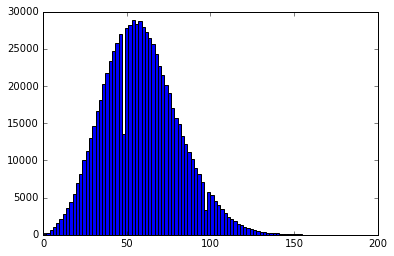

In [124]:
plt.figure(figsize = (12,12))
plt.subplot(221)


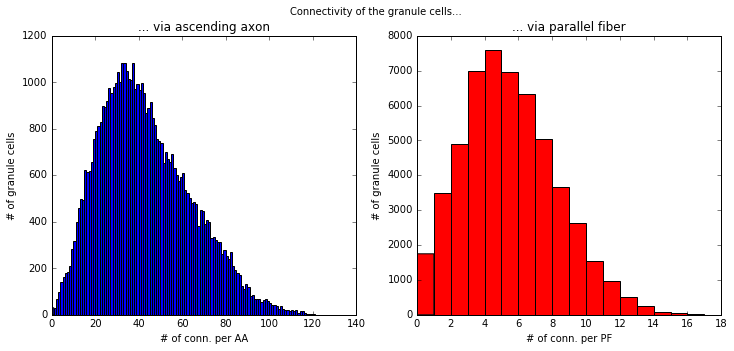

In [120]:
plt.figure(figsize = (12,5))

plt.subplot(121)

so_aa = con_per_cell(src_aa, len(gran))
_ = plt.hist(so_aa, int(max(so_aa)))
label_graph ('... via ascending axon', '# of conn. per AA', '# of granule cells')

plt.subplot(122)
so_pf = con_per_cell(src_pf, len(gran))
_ = plt.hist(so_pf, int(max(so_pf)), color = 'r')
label_graph ('... via parallel fiber', '# of conn. per PF', '# of granule cells')

plt.suptitle('Connectivity of the granule cells...')


### Golgi cell to Granule cell

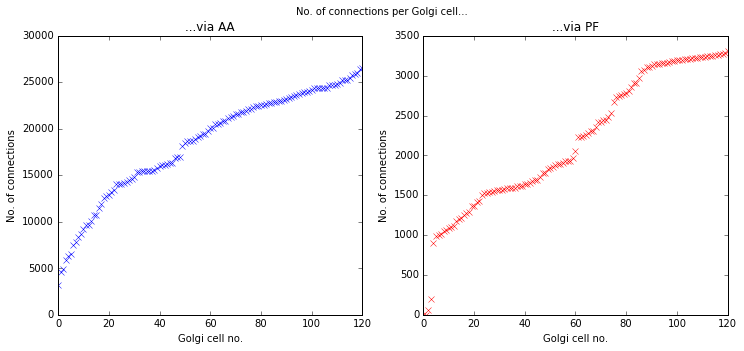

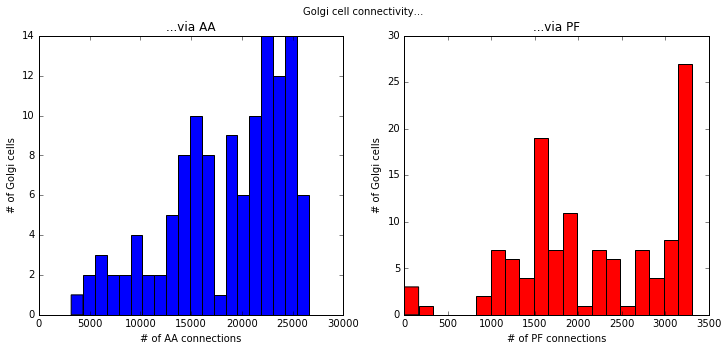

In [10]:
to_pf = con_per_cell(tar_pf, len(gol)-1)
to_aa = con_per_cell(tar_aa, len(gol)-1)
single_point_fig = True
hist_fig = True
n_bins = 20

if single_point_fig:
    plt.figure(figsize = (12,5))
    
    plt.subplot(121)
    plt.plot(np.sort(to_aa), 'bx')
    label_graph('...via AA', 'Golgi cell no.', 'No. of connections')
    
    plt.subplot(122)
    plt.plot(np.sort(to_pf), 'rx')
    label_graph('...via PF', 'Golgi cell no.', 'No. of connections')
    
    plt.suptitle('No. of connections per Golgi cell...')
    

if hist_fig:
    plt.figure(figsize = (12,5))
    
    plt.subplot(121)
    _ = plt.hist(to_aa, n_bins)
    label_graph('...via AA', '# of AA connections', '# of Golgi cells')

    plt.subplot(122)
    _ = plt.hist(to_pf,n_bins, color = 'r')
    label_graph('...via PF', '# of PF connections', '# of Golgi cells')
    
    plt.suptitle('Golgi cell connectivity...')

## Cell and connection visualization

### Show all Granule cells that connect to a certain Golgi cell

/home/ines/Applications/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


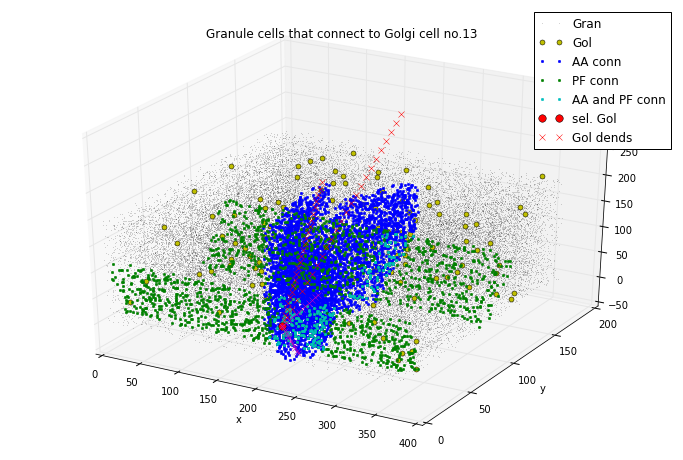

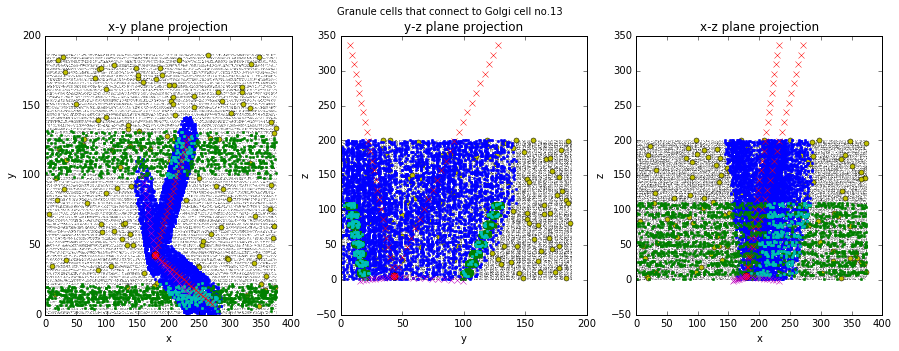

In [87]:
cell_id = 13
select_aa = True
select_pf = True
plot_dends = True

go_sel = gol[cell_id]
if select_aa: 
    idx_aa = np.unique(np.array(src_aa)[np.isclose(tar_aa, cell_id)])
    grs_aa = gran[idx_aa,:]
if select_pf: 
    idx_pf = np.unique(np.array(src_pf)[np.isclose(tar_pf, cell_id)])
    grs_pf = gran[idx_pf,:]
if select_aa and select_pf:
    idx_both = np.intersect1d(idx_pf, idx_aa)
    grs_both = gran[idx_both,:]
if plot_dends:
    ad = a_dend[cell_id]
    bd = b_dend[cell_id]
    
ms_gran = 5.0
ms_gol = 5.0


plt.figure(figsize = (12,8))
ax = plt.gcf().gca(projection='3d')
#plot ground population
plot3d(ax, gran, 'k.', markersize = 0.2, label = 'Gran')
plot3d(ax, gol, 'yo', markersize = ms_gol, label = 'Gol')
#plot selected cell and connected GrC
if select_aa: plot3d(ax, grs_aa, 'b.', markersize = ms_gran, label = 'AA conn')
if select_pf: plot3d(ax, grs_pf, 'g.', markersize = ms_gran, label = 'PF conn')
if select_aa and select_pf: plot3d(ax, grs_both,'c.', markersize = ms_gran, label = 'AA and PF conn')
plot3d(ax, go_sel, 'ro', markersize = 1.5*ms_gol, label = 'sel. Gol')
#plot dendrites
if plot_dends:
    plot3d(ax, ad, 'rx', label = 'Gol dends')
    plot3d(ax, bd, 'mx')
    
label_graph('Granule cells that connect to Golgi cell no.'+ str(cell_id), 'x', 'y')
plt.legend(loc = 0)


plt.figure(figsize=(15,5))
graph_labels = [['x-y plane projection', 'x', 'y'], ['y-z plane projection', 'y', 'z'], ['x-z plane projection', 'x', 'z']]

for i, [j, k] in enumerate([[0,1], [1,2], [0,2]]):
    plt.subplot(1,3,i+1)
    #plot ground populations
    plt.plot(gran[:,j], gran[:,k],  'k.', markersize = 0.2)
    plt.plot(gol[:,j], gol[:,k], 'yo', markersize = ms_gol)
    #plot selected cell and connected GrC
    if select_aa: plt.plot(grs_aa[:,j], grs_aa[:,k], 'b.', markersize = ms_gran)
    if select_pf: plt.plot(grs_pf[:,j], grs_pf[:,k], 'g.', markersize = ms_gran)
    if select_aa and select_pf: plt.plot(grs_both[:,j], grs_both[:,k], 'c.', markersize = ms_gran)
    plt.plot(go_sel[j], go_sel[k], 'ro', markersize = 1.5*ms_gol) 
        
    if plot_dends:
        plt.plot(ad[:,j], ad[:,k], 'rx')
        plt.plot(bd[:,j], bd[:,k], 'mx')

    label_graph(*graph_labels[i])
    
    plt.suptitle('Granule cells that connect to Golgi cell no.'+str(cell_id))
    

### Show all Golgi cells that connect to a certain Granule cell

/home/ines/Applications/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Corresponding lengths are:  [ 633.01954403  397.90640434  264.54297645  328.65072244  634.76814763
  613.20118824  629.77075812  353.38011594  387.53784301  589.7964981
  596.692844  ]


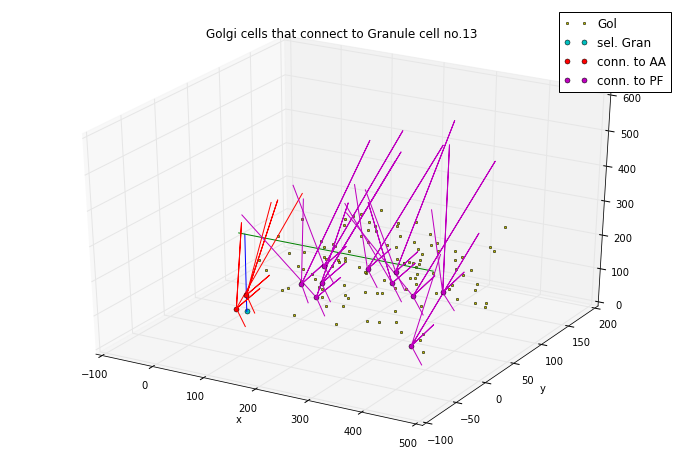

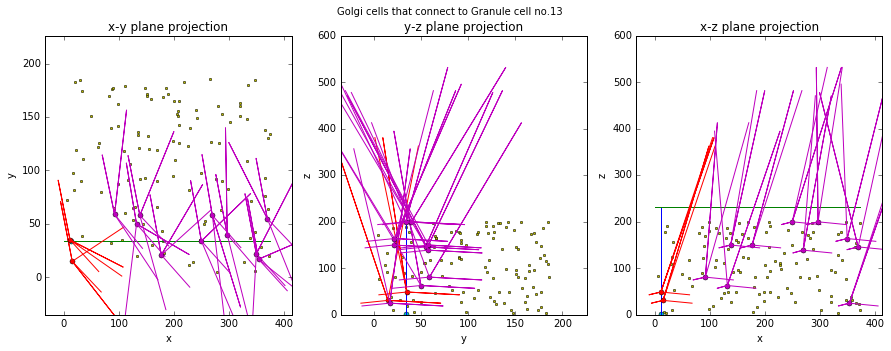

In [108]:
cell_id = 13
select_aa = True
select_pf = True
plot_dends = True

len_pf = 1000
cut_pf = True
grs = gran[cell_id,:]
aa_co = np.array([gran[cell_id,:], granT[cell_id,:]])
pf_co = np.array([granT[cell_id,:]-np.array([len_pf,0,0]),granT[cell_id,:]+np.array([len_pf, 0,0])])
if cut_pf:
    pf_co[0,0] = max ([pf_co[0,0], 0])
    pf_co[1,0] = min ([pf_co[1,0], max(gran[:, 0])]) 

if select_aa: idx_aa = np.unique(np.array(tar_aa)[np.isclose(src_aa, cell_id)])
if select_pf: idx_pf = np.unique(np.array(tar_pf)[np.isclose(src_pf, cell_id)])
    
    
ms_gran = 5.0
ms_gol = 5.0


plt.figure(figsize = (12,8))
ax = plt.gcf().gca(projection='3d')
#plot ground population, this time only Golgi...
plot3d(ax, gol, 'yo', markersize = 0.5*ms_gol, label = 'Gol')
#plot selected Granule cell
plot3d(ax, grs, 'co', markersize = ms_gran,label = 'sel. Gran')
plot3d(ax, aa_co, 'b')
plot3d(ax, pf_co, 'g')
#plot Golgi cells and Golgi cell dendrites
if select_aa: 
    first = True
    for c in idx_aa:
        if first:
            plot3d(ax, gol[c,:], 'ro', markersize = ms_gol, label = 'conn. to AA')
            first = False
        else: plot3d(ax, gol[c,:], 'ro', markersize = ms_gol)
        if plot_dends:
            plot3d (ax, a_dend[c,:], 'r')
            plot3d (ax, b_dend[c,:], 'r')
if select_pf: 
    first = True
    for c in idx_pf:
        if first:
            plot3d(ax, gol[c,:], 'mo', markersize = ms_gol, label = 'conn. to PF')
            first = False
        else: plot3d(ax, gol[c,:], 'mo', markersize = ms_gol)
        if plot_dends:
            plot3d (ax, a_dend[c,:], 'm')
            plot3d (ax, b_dend[c,:], 'm')
        

label_graph('Golgi cells that connect to Granule cell no.'+str(cell_id), 'x', 'y')
plt.legend(loc = 0)

plt.figure(figsize=(15,5))
graph_labels = [['x-y plane projection', 'x', 'y'], ['y-z plane projection', 'y', 'z'], ['x-z plane projection', 'x', 'z']]

for i, [j, k] in enumerate([[0,1], [1,2], [0,2]]):
    plt.subplot(1,3,i+1)
    plt.plot(gol[:,j], gol[:,k], 'yo', markersize = 0.5*ms_gol)
    #plot selected cell and connected GrC
    plt.plot(grs[j], grs[k], 'co', markersize = ms_gran)
    plt.plot(aa_co[:,j], aa_co[:,k], 'b')
    plt.plot(pf_co[:,j], pf_co[:,k], 'g')
    
    #plot Golgi cells and Golgi cell dendrites
    if select_aa: 
        for c in idx_aa:
            plt.plot(gol[c,j], gol[c,k],'ro', markersize = ms_gol)
            if plot_dends:
                plt.plot(a_dend[c,:,j], a_dend[c,:,k], 'r')
                plt.plot(b_dend[c,:,j], b_dend[c,:,k], 'r')
    if select_pf: 
        for c in idx_pf:
            plt.plot(gol[c,j], gol[c,k],'mo', markersize = ms_gol)
            if plot_dends:
                plt.plot(a_dend[c,:,j], a_dend[c,:,k], 'm')
                plt.plot(b_dend[c,:,j], b_dend[c,:,k], 'm')

    if True: 
        if not j == 2: plt.xlim([min(gol[:,j])-40, max(gol[:,j])+40])
        if not k == 2: plt.ylim([min(gol[:,k])-40, max(gol[:,k])+40])
    label_graph(*graph_labels[i])
    
    plt.suptitle('Golgi cells that connect to Granule cell no.'+str(cell_id))
  


## Segments and distance

### Segments
Things to check for:
- The first column corresponds to the number of segments- is that the number you expected?
- The second column corresponds to the dendrite number.
- For AA, you would expect lower segment numbers to have a higher number of found connections, because for those segments, both basal and apical dendrites can connect, whereas for the higher segments, only basal dendrites can connect.
- For PF, you expect the dendrites 1 and 2 (the basal dendrites) to have 0 connections, because those dendrites are in the granule cell layer whereas the parallel fiber is in the molecular layer
- For PF, you would expect both high and low segment numbers to have fewer connections, because those segments are in the molecular layer only if the soma of the cell is very high or very low.

In [116]:
def con_per_seg (so):
    fc = so[:,0]
    sc = so[:,1]
    print ('First (segment number)')
    for i in np.unique(fc):
        idx = np.isclose(fc, i)
        print (i, ': n =', sum(idx))
    print ('Second (dendrite number)')
    for i in np.unique(sc):
        idx = np.isclose(sc, i)
        print (i, ': n =', sum(idx))
        
print ('AA stats:')
con_per_seg(np.array(seg_aa))
print (' ')
print ('PF stats:')
con_per_seg(np.array(seg_pf))

AA stats:
First (segment number)
1.0 : n = 685579
2.0 : n = 596709
3.0 : n = 501763
4.0 : n = 241899
5.0 : n = 222860
Second (dendrite number)
1.0 : n = 380415
2.0 : n = 414447
3.0 : n = 686883
4.0 : n = 767065
 
PF stats:
First (segment number)
1.0 : n = 7676
2.0 : n = 48143
3.0 : n = 75641
4.0 : n = 84541
5.0 : n = 47280
Second (dendrite number)
3.0 : n = 123617
4.0 : n = 139664


### Distance

Things to check for:
- AA connections should have distances that are maximally aa_length
- PF connecions should have distances that are at least aa_length.

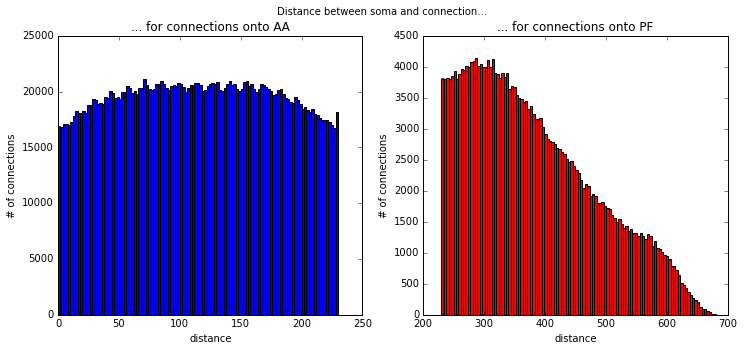

In [119]:
n_bins = 115

plt.figure(figsize = (12,5))

plt.subplot(121)
_ = plt.hist(np.array(dis_aa), n_bins)
label_graph('... for connections onto AA', 'distance', '# of connections')

plt.subplot(122)
_ = plt.hist(np.array(dis_pf),n_bins, color = 'r')
label_graph('... for connections onto PF', 'distance', '# of connections')

plt.suptitle('Distance between soma and connection...')

